In [1]:
import xarray as xr
import glob
import numpy as np

import tensorflow as tf

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import linregress
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import matplotlib as mpl 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors
import cmasher as cmr

import sys
sys.path.append("../functions/")

import preprocessing
import experiment_settings
import build_model
import metricplots
import allthelinalg
import analysisplots
import SCA

import importlib as imp

# pretty plots
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.sans-serif']=['Verdana']

params = {"ytick.color": "k",
          "xtick.color": "k",
          "axes.labelcolor": "k",
          "axes.edgecolor": "k"}
plt.rcParams.update(params)

In [2]:
modelpath = "../models/"
experiment_name = "allcmodel-tos_allcmodel-tos_1-5yearlead"
experiment_dict = experiment_settings.get_experiment_settings(experiment_name)
filefront = experiment_dict["filename"]
filename = modelpath + experiment_dict["filename"]
modellist = experiment_dict["modellist"]
outbounds = experiment_dict["outbounds"]
trainvariants = experiment_dict["trainvariants"]
valvariants = experiment_dict["valvariants"]
testvariants = experiment_dict["testvariants"]
seedlist = experiment_dict["seeds"]
run = experiment_dict["run"]
leadtime = experiment_dict["leadtime"]
year1 = 1851+run

lon, lat = preprocessing.outlonxlat(experiment_dict)
lon = np.asarray(lon)
lat = np.asarray(lat)
centre = (outbounds[2]+outbounds[3])/2
projection = ccrs.EqualEarth(central_longitude=centre)
inres = experiment_dict["inres"]
transform = ccrs.PlateCarree()
obsyearvec_ERSST = np.arange(1854+3*run+leadtime,2024,)
obsyearvec_HadISST = np.arange(1870+3*run+leadtime,2024,)
modelyearvec = np.arange(year1+2*run+leadtime,2015)
latvec = np.arange(-90+inres/2,90+inres/2,inres)
lonvec = np.arange(0+inres/2,360+inres/2,inres)

weights = np.meshgrid(lon,lat)[1]
latweights = np.sqrt(np.cos(np.deg2rad(weights)))

In [3]:
datafile = "../processed_data/" + filefront + "alldata_nodetrend.npz"

imp.reload(preprocessing)

filecheck = glob.glob(datafile)

if len(filecheck)==0:

    alldata = preprocessing.grab_all_data(experiment_dict)
    print('got data, converting....')
    alldata = np.asarray(alldata)

    np.savez(datafile,alldata=alldata)

else:
    alldataz = np.load(datafile)
    alldata = alldataz["alldata"]



In [4]:
imp.reload(preprocessing)

ERSSTnodetrend,HadISSTnodetrend = preprocessing.grab_obs_nodetrend(experiment_dict)
ERSSTdetrend,HadISSTdetrend = preprocessing.grab_obs_detrend(experiment_dict)

In [5]:
alldata_ERSSTtime = alldata[:,:,-1*ERSSTnodetrend.shape[0]:]
alldata_HadISSTtime = alldata[:,:,-1*HadISSTnodetrend.shape[0]:]

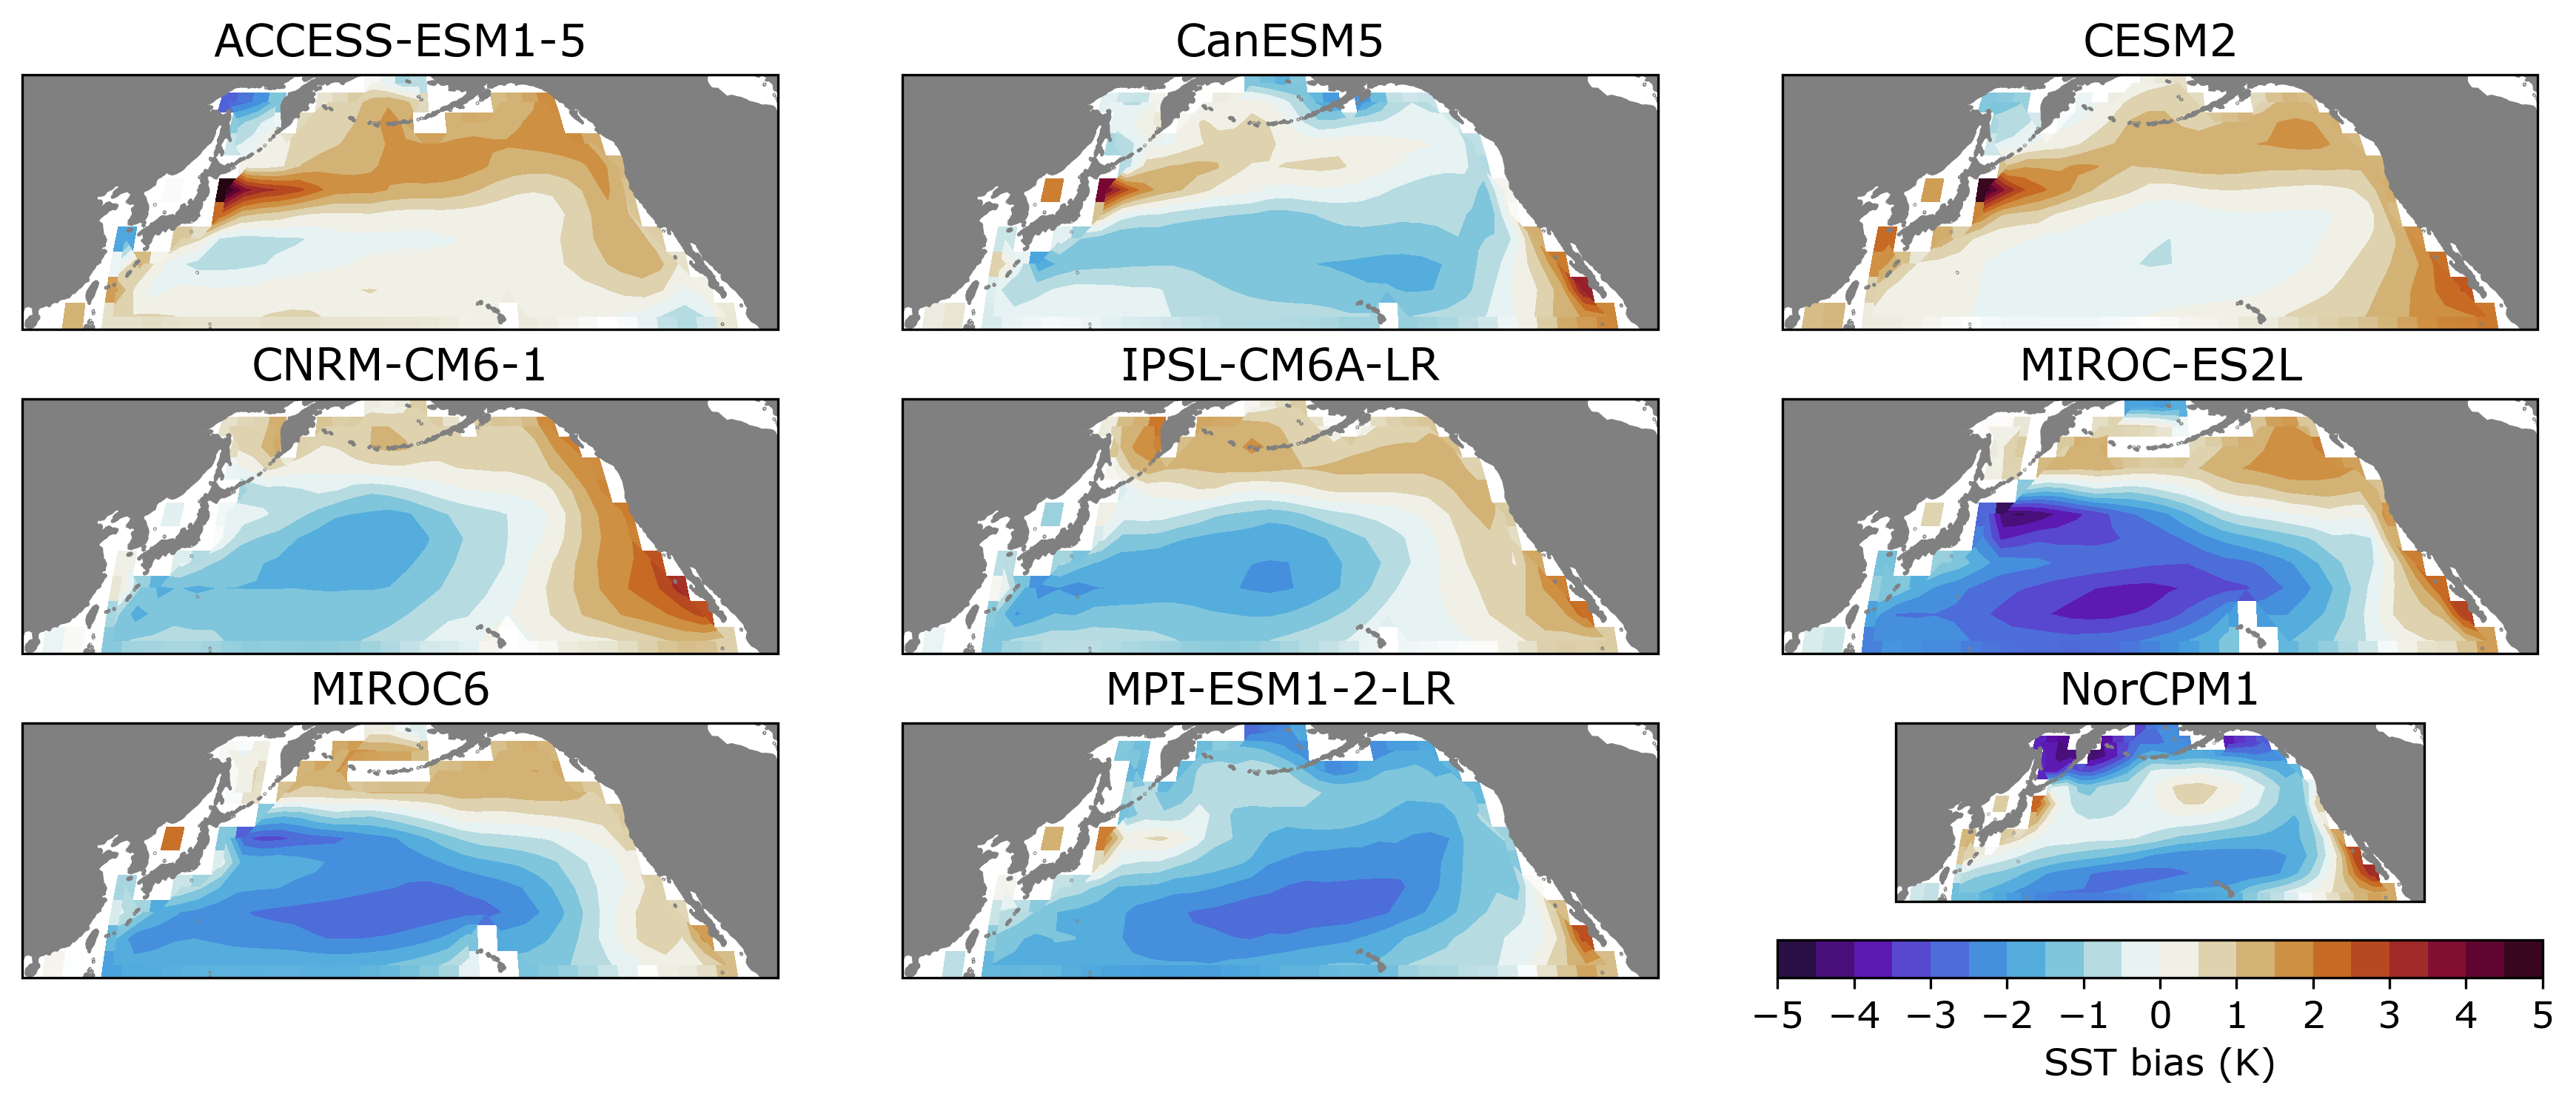

In [6]:
projection = ccrs.EqualEarth(central_longitude=180)
transform = ccrs.PlateCarree()

continents = 'grey'

plt.figure(figsize=(12,5))

for imodel in range(9):

    allbias = alldata_ERSSTtime[imodel]-np.asarray(ERSSTnodetrend)[np.newaxis]

    allbiasmean = np.mean(allbias,axis=(0,1))

    ax=plt.subplot(3,3,imodel+1,projection=projection)
    ax.pcolormesh(lon,lat,allbiasmean,vmin=-5,vmax=5,cmap=cmr.fusion_r,transform=transform)
    c0=ax.contourf(lon,lat,allbiasmean,np.arange(-5,5.5,0.5),cmap=cmr.fusion_r,transform=transform)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor=continents))
    plt.title(modellist[imodel])

cbar=plt.colorbar(c0,orientation='horizontal',ticks=np.arange(-5,6))
cbar.ax.set_xlabel("SST bias (K)")
plt.tight_layout()


0.42414117649414745
0.25522220887702923


Text(-1.217, 0.16, 'p = 0.26')

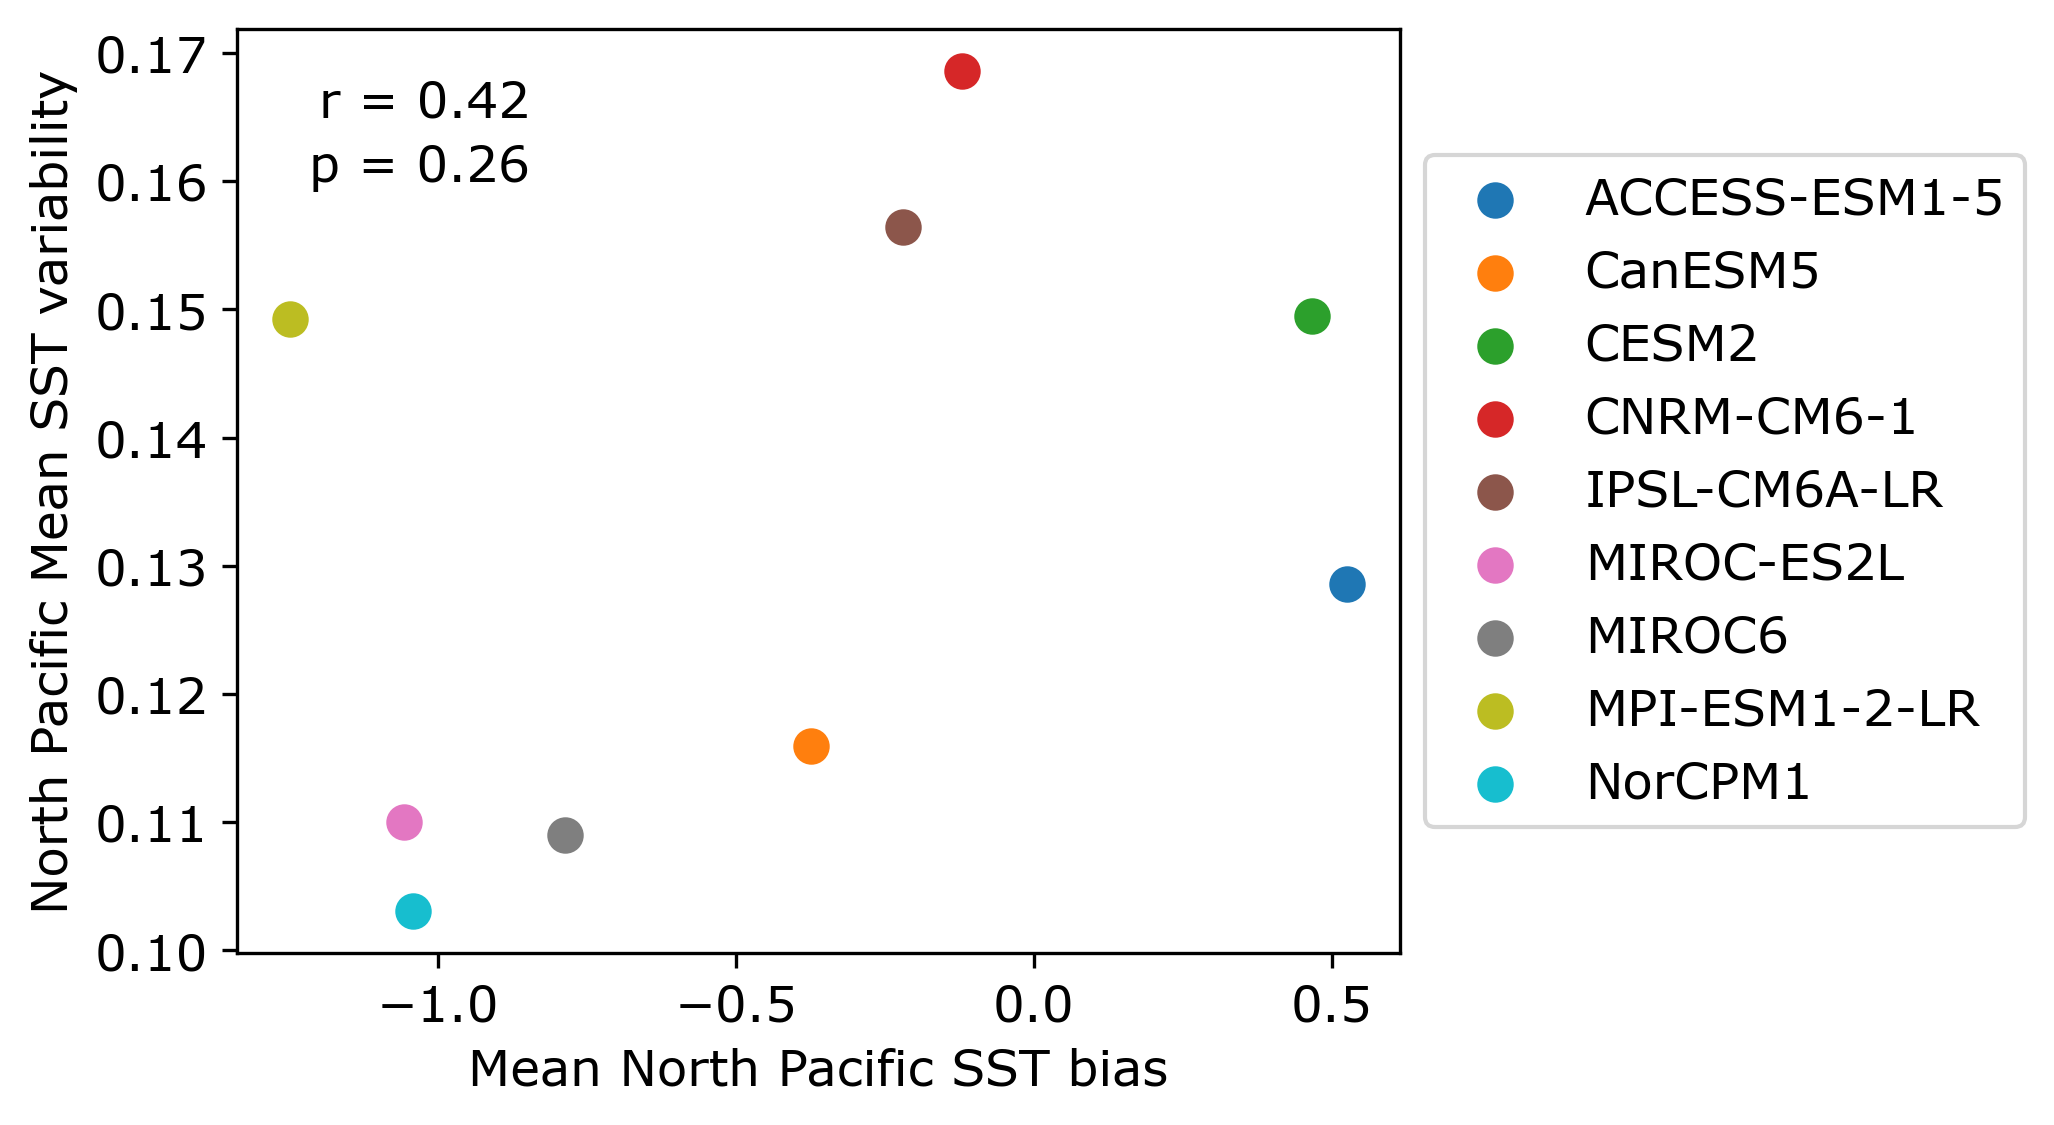

In [23]:
plt.figure(figsize=(5,4))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10(np.linspace(0,1,9)))

bs = []
vs = []

for imodel in range(9):

    alldata_ERSSTtime_ensmean = np.mean(alldata_ERSSTtime[imodel],axis=0)

    allbias = alldata_ERSSTtime_ensmean-np.asarray(ERSSTnodetrend)

    # allbiasmean = np.mean(allbias,axis=0)
    allbiasmean = np.nanmean(allbias*latweights[np.newaxis])
    allbiasmeanmean = np.nanmean(allbiasmean)

    alldata_ERSSTtime_mean = np.nanmean((alldata_ERSSTtime[imodel]-alldata_ERSSTtime_ensmean[np.newaxis])*latweights[np.newaxis,np.newaxis],axis=(2,3))
    alldata_ERSSTtime_std = np.nanstd(alldata_ERSSTtime_mean,axis=(0,1))
    
    plt.scatter(allbiasmeanmean,alldata_ERSSTtime_std,marker='o',label=modellist[imodel],s=60)

    bs.append(allbiasmeanmean)
    vs.append(alldata_ERSSTtime_std)

plt.xlabel('Mean North Pacific SST bias')
plt.ylabel("North Pacific Mean SST variability")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# r,p=spearmanr(np.asarray(bs),np.asarray(vs))
r,p=pearsonr(np.asarray(bs),np.asarray(vs))
print(r)
print(p)
plt.text(-1.2,0.165,'r = ' + '{0:.2f}'.format(r))
plt.text(-1.217,0.16,'p = ' + '{0:.2f}'.format(p))
# plt.text(np.min(np.asarray(bs)),np.max(np.asarray(vs)),r)
# plt.text(np.min(np.asarray(bs)),np.max(np.asarray(vs))-0.01,p)


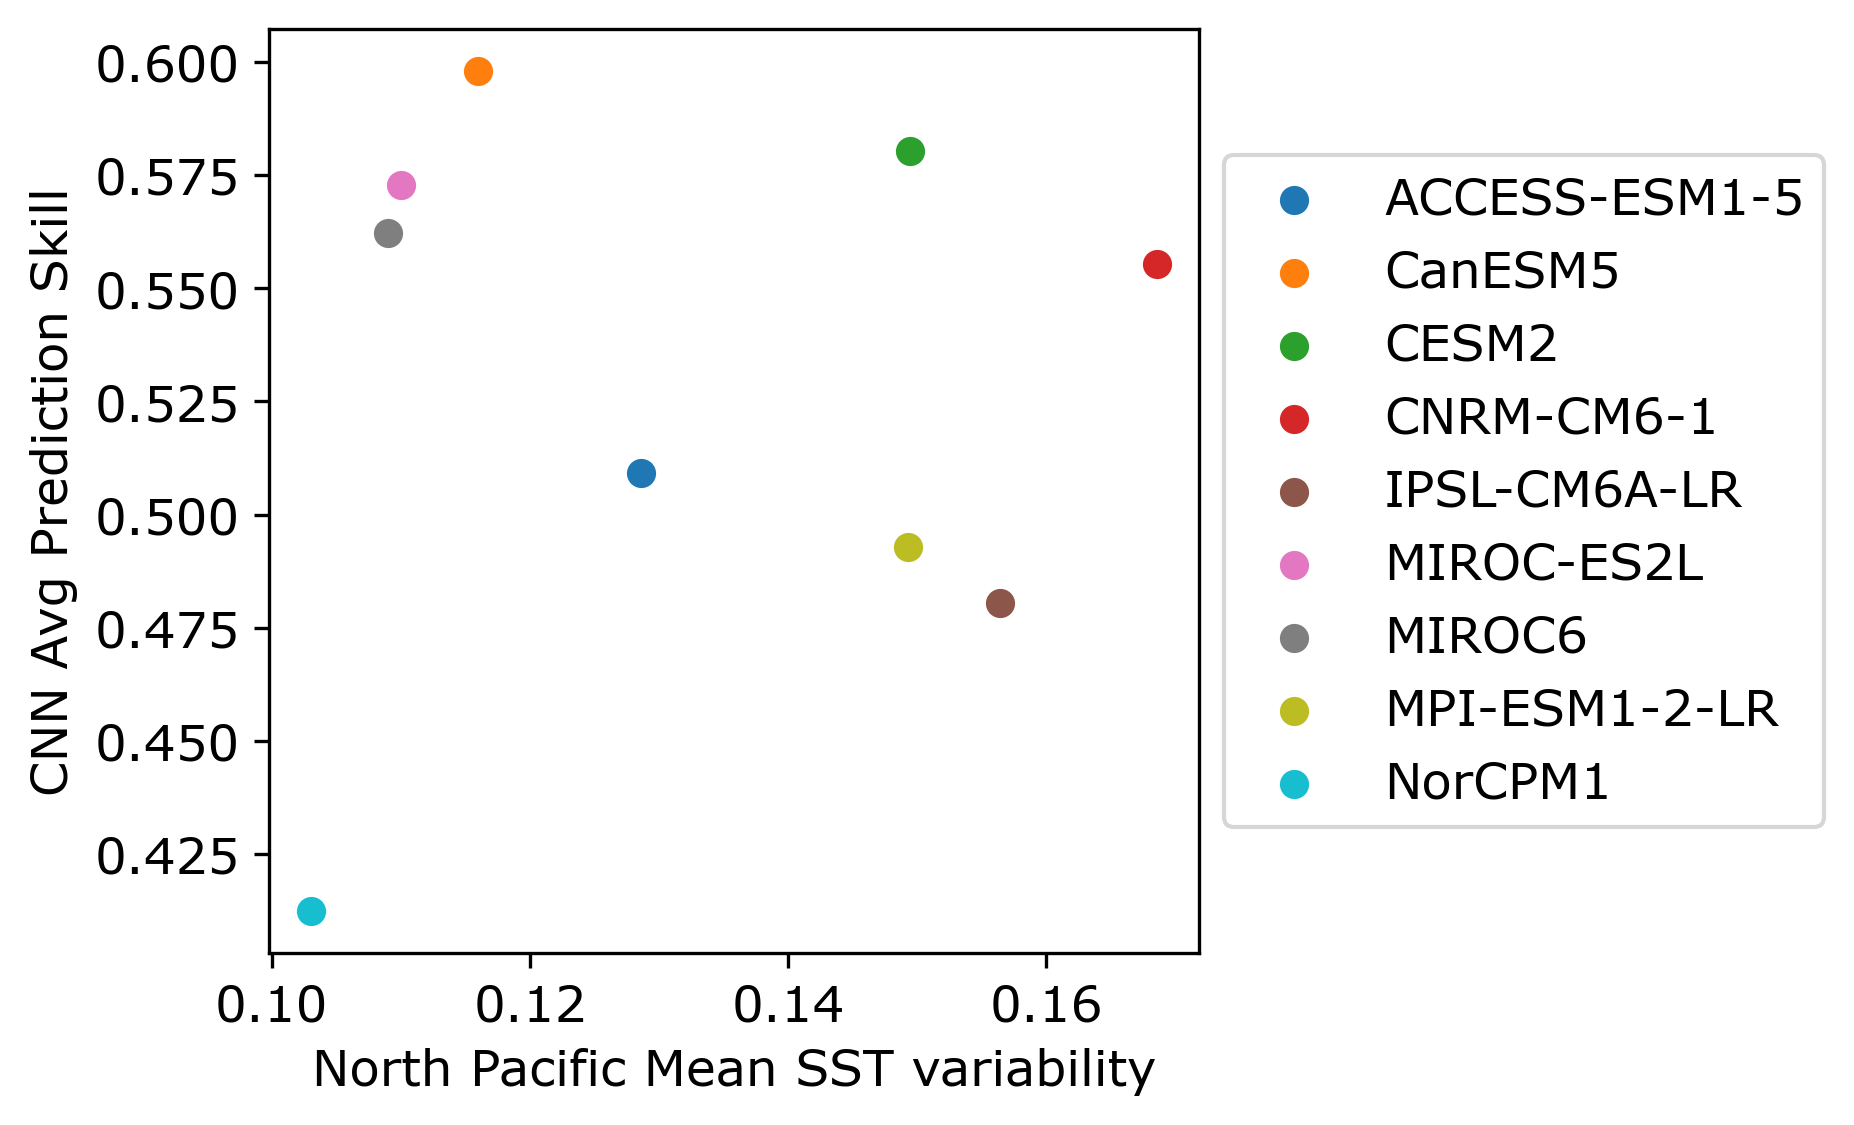

In [18]:
modelpearsonsobj = np.load("../processed_data/modelpearsons_polydetrend.npz")
modelpearsons = modelpearsonsobj["modelpearsons"]
modelskill = np.mean(modelpearsons,axis=1)

plt.figure(figsize=(4,4))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10(np.linspace(0,1,9)))

vs = []

for imodel in range(9):

    alldata_ERSSTtime_ensmean = np.mean(alldata_ERSSTtime[imodel],axis=0)

    allbias = alldata_ERSSTtime_ensmean-np.asarray(ERSSTnodetrend)

    # allbiasmean = np.mean(allbias,axis=0)
    allbiasmean = np.nanmean(allbias*latweights[np.newaxis])
    allbiasmeanmean = np.nanmean(allbiasmean)

    alldata_ERSSTtime_mean = np.nanmean((alldata_ERSSTtime[imodel]-alldata_ERSSTtime_ensmean[np.newaxis])*latweights[np.newaxis,np.newaxis],axis=(2,3))
    alldata_ERSSTtime_std = np.nanstd(alldata_ERSSTtime_mean,axis=(0,1))
    
    plt.scatter(alldata_ERSSTtime_std,modelskill[imodel],marker='o',label=modellist[imodel])
    
    vs.append(alldata_ERSSTtime_std)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("North Pacific Mean SST variability")
plt.ylabel("CNN Avg Prediction Skill")

r,p=spearmanr(modelskill,np.asarray(vs))



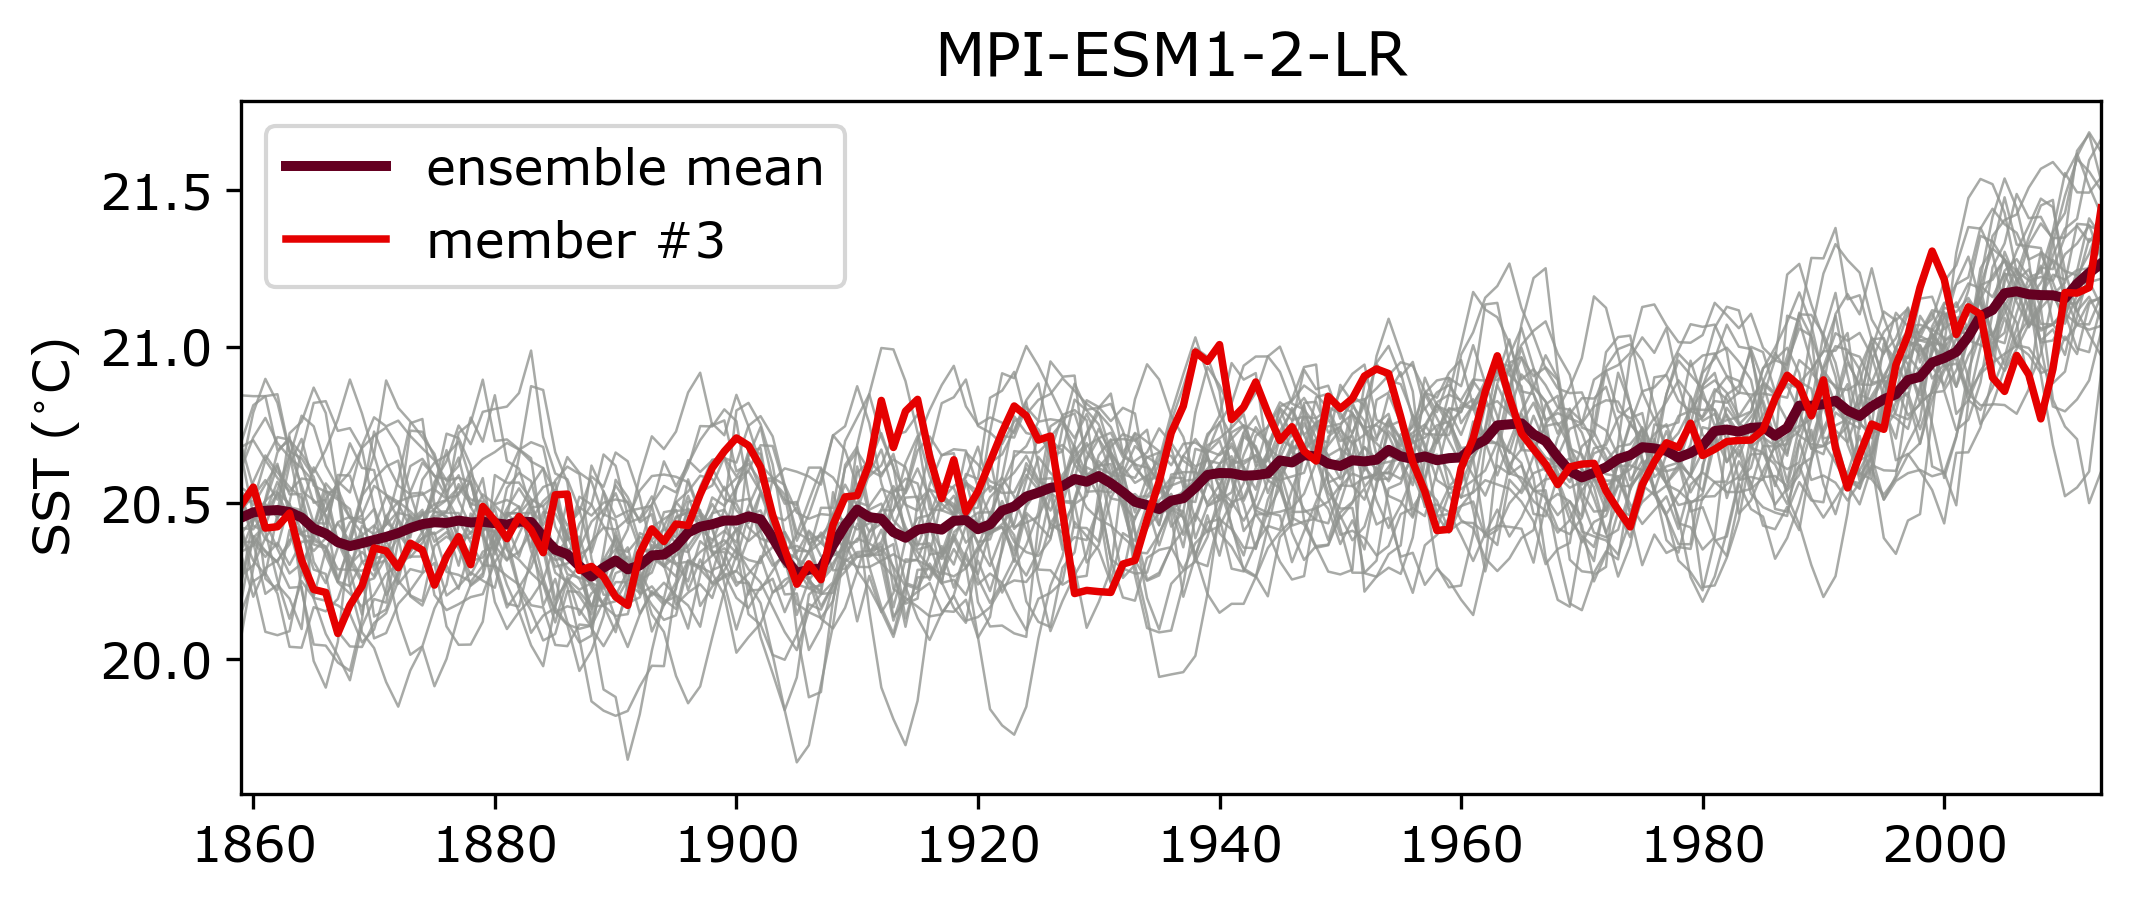

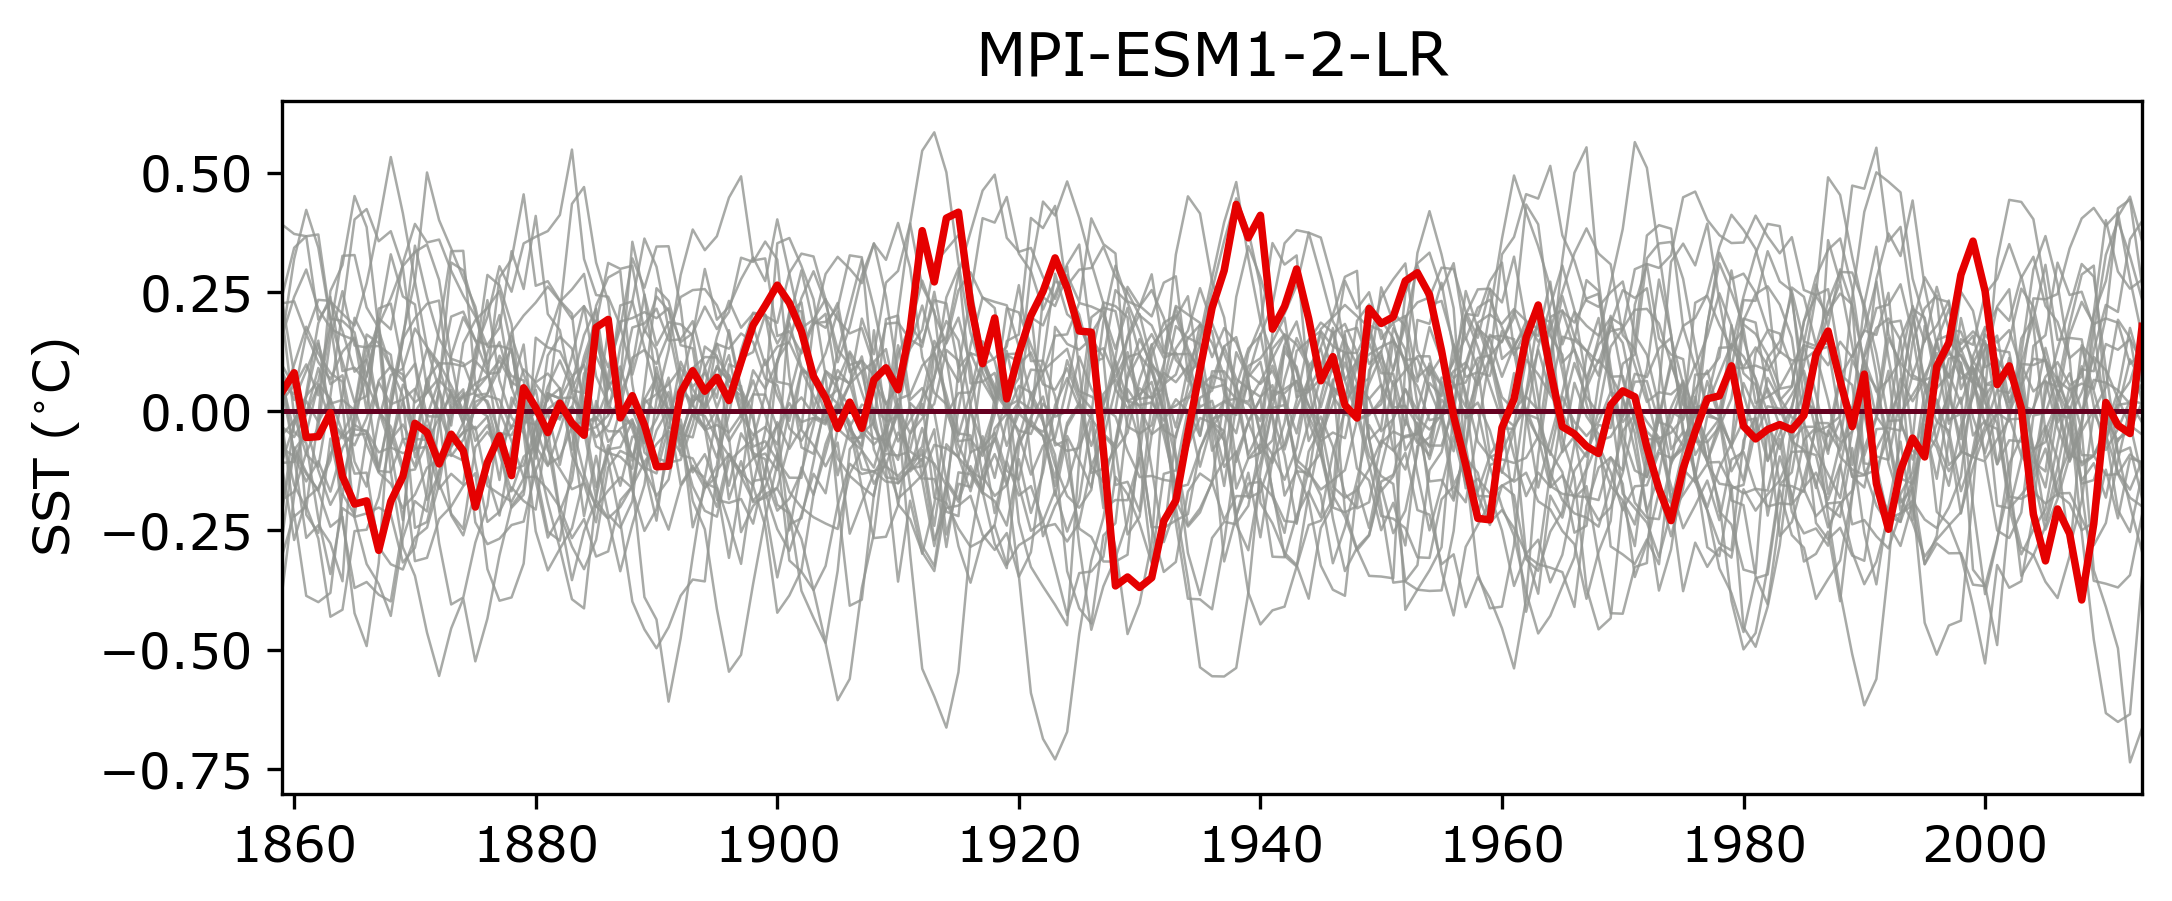

In [9]:
alldata_ERSSTtime.shape
yearvecplot = np.arange(2014-ERSSTnodetrend.shape[0]+5,2014)

imodel = 7
modelplot = modellist[imodel]
ilatsel = 3
ilonsel = 10

cmodelplot = np.transpose(alldata_ERSSTtime[imodel,:,:,ilatsel,ilonsel])
cmodelplot_run = np.empty((len(yearvecplot),30))

for i in range(len(yearvecplot)):
    cmodelplot_run[i] = np.mean(cmodelplot[i:i+5],axis=0)


plt.figure(figsize=(8,3))

plt.plot(yearvecplot,cmodelplot_run,color='xkcd:grey',linewidth=0.6,alpha=0.8)
plt.plot(yearvecplot,np.mean(cmodelplot_run,axis=1),color='xkcd:maroon',linewidth=2.4,label='ensemble mean')
plt.plot(yearvecplot,cmodelplot_run[:,3],color='xkcd:red',linewidth=1.8,label='member #3')
plt.ylabel('SST ($^{\circ}$C)')
plt.xlim(1859,2013)
plt.title(modelplot)
plt.legend()
# plt.tight_layout()

plt.show()

plt.figure(figsize=(8,3))

plt.plot(yearvecplot,cmodelplot_run-np.mean(cmodelplot_run,axis=1,keepdims=True),color='xkcd:grey',linewidth=0.6,alpha=0.8)
plt.plot(yearvecplot,np.mean(cmodelplot_run,axis=1)-np.mean(cmodelplot_run,axis=1),color='xkcd:maroon',linewidth=1.2,label='ensemble mean')
plt.plot(yearvecplot,cmodelplot_run[:,3]-np.mean(cmodelplot_run,axis=1),color='xkcd:red',linewidth=1.8,label='member #3')
plt.ylabel('SST ($^{\circ}$C)')
plt.xlim(1859,2013)
plt.title(modelplot)
# plt.legend()
# plt.tight_layout()

plt.show()

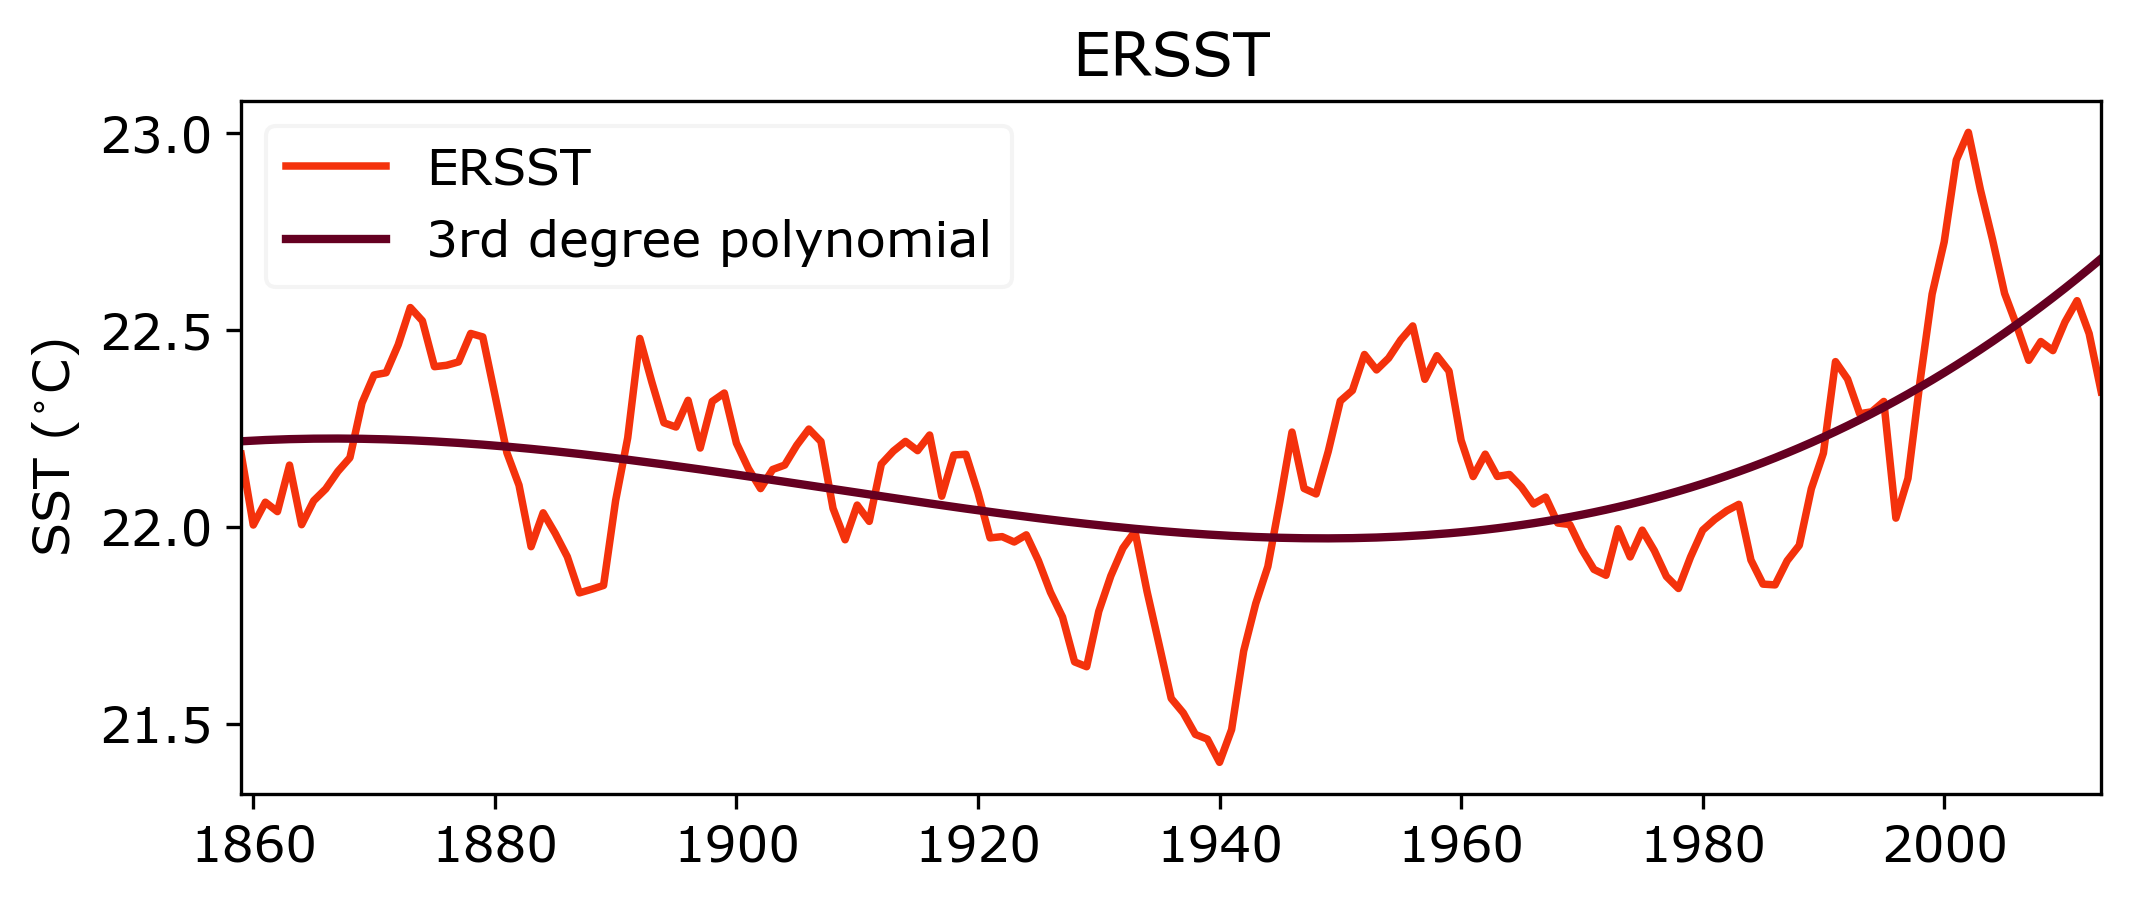

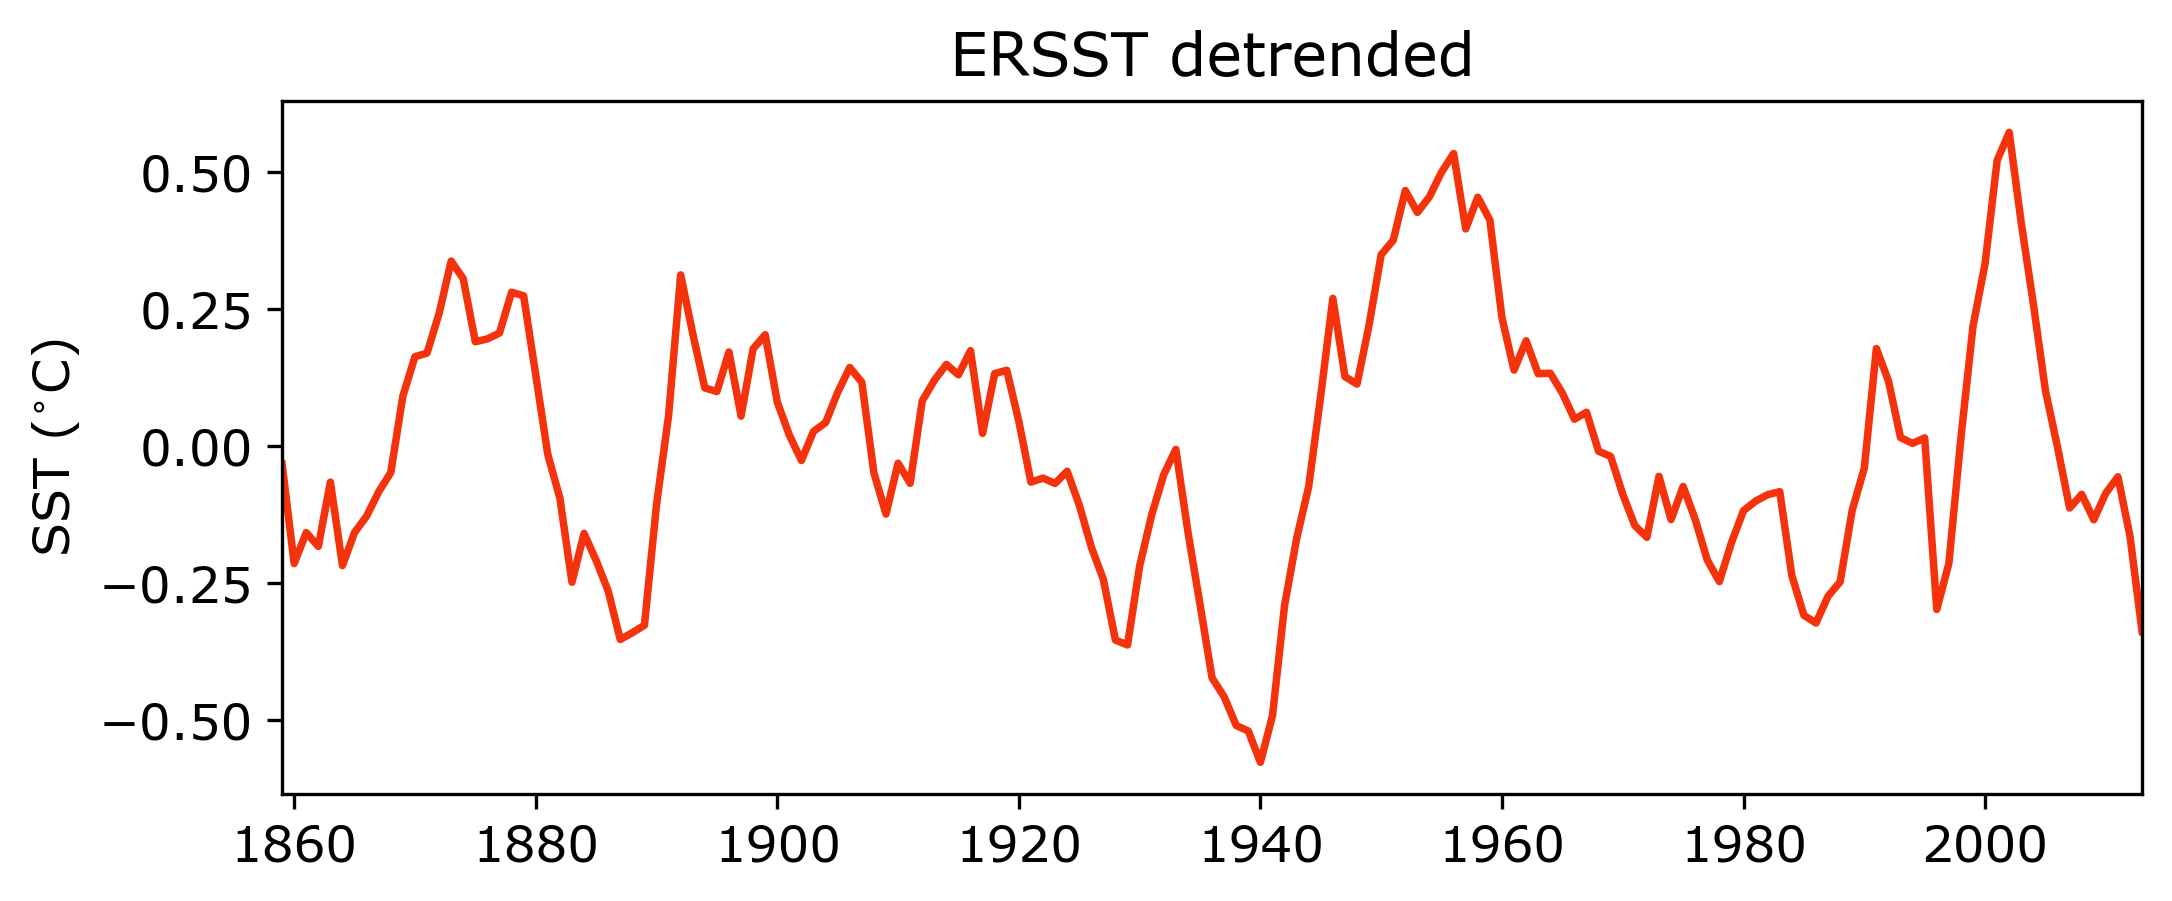

In [10]:
ERSSTrun = np.empty((len(yearvecplot)))
for i in range(len(yearvecplot)):
    ERSSTrun[i] = np.mean(ERSSTnodetrend[i:i+5,ilatsel,ilonsel])

polyfit = np.polyfit(yearvecplot,ERSSTrun,deg=3)
polynomialplot = polyfit[0]*yearvecplot**3+polyfit[1]*yearvecplot**2+polyfit[2]*yearvecplot+polyfit[3]

plt.figure(figsize=(8,3))

plt.plot(yearvecplot,ERSSTrun,color='xkcd:vermillion',linewidth=1.8,label="ERSST")
plt.plot(yearvecplot,polynomialplot,color='xkcd:maroon',linewidth=2,label="3rd degree polynomial")
plt.ylabel('SST ($^{\circ}$C)')
plt.xlim(1859,2013)
plt.title('ERSST')
plt.legend(fancybox=True, framealpha=0.2)
# plt.tight_layout()

plt.show()

plt.figure(figsize=(8,3))

plt.plot(yearvecplot,ERSSTrun-polynomialplot,color='xkcd:vermillion',linewidth=1.8)
# plt.plot(yearvecplot,color='xkcd:maroon',linewidth=1.)
plt.ylabel('SST ($^{\circ}$C)')
plt.xlim(1859,2013)
plt.title('ERSST detrended')
# plt.legend()
# plt.tight_layout()

plt.show()

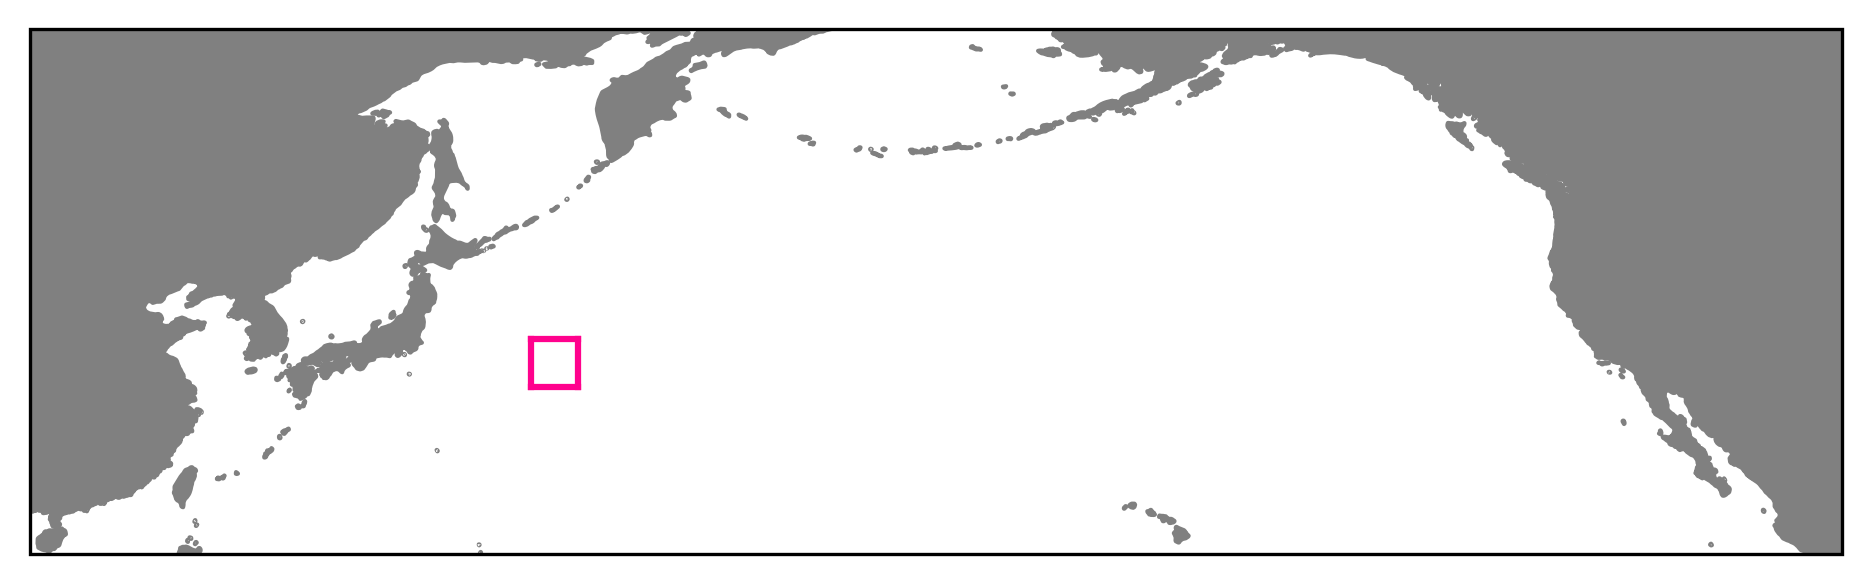

In [11]:
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree(central_longitude=180))

ax.pcolormesh(lon,lat,np.empty((len(lat),len(lon)))+np.nan,transform=transform)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor=continents))
ax.plot([lon[ilonsel],lon[ilonsel+1]],[lat[ilatsel],lat[ilatsel]],transform=transform,color='xkcd:hot pink')
ax.plot([lon[ilonsel],lon[ilonsel+1]],[lat[ilatsel+1],lat[ilatsel+1]],transform=transform,color='xkcd:hot pink')
ax.plot([lon[ilonsel],lon[ilonsel]],[lat[ilatsel],lat[ilatsel+1]],transform=transform,color='xkcd:hot pink')
ax.plot([lon[ilonsel+1],lon[ilonsel+1]],[lat[ilatsel],lat[ilatsel+1]],transform=transform,color='xkcd:hot pink')

plt.tight_layout()

